# Aim

The aim of this workbook is to use the functions created in [Building-a-deep-neural-network](https://github.com/Charlvdh/Data-Science/tree/master/deep_learning/Building-a-deep-neural-network) to improve on the cat classification task in [Logistic Regression with a Neural Network Mindset](https://github.com/Charlvdh/Data-Science/tree/master/deep_learning/Logistic-regression-with-a-neural-network-mindset).

## 1 - Packages

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - The dataset

We will be using the same datasets as in [Logistic Regression with a Neural Network Mindset](https://github.com/Charlvdh/Data-Science/tree/master/deep_learning/Logistic-regression-with-a-neural-network-mindset) for comparability's sake.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

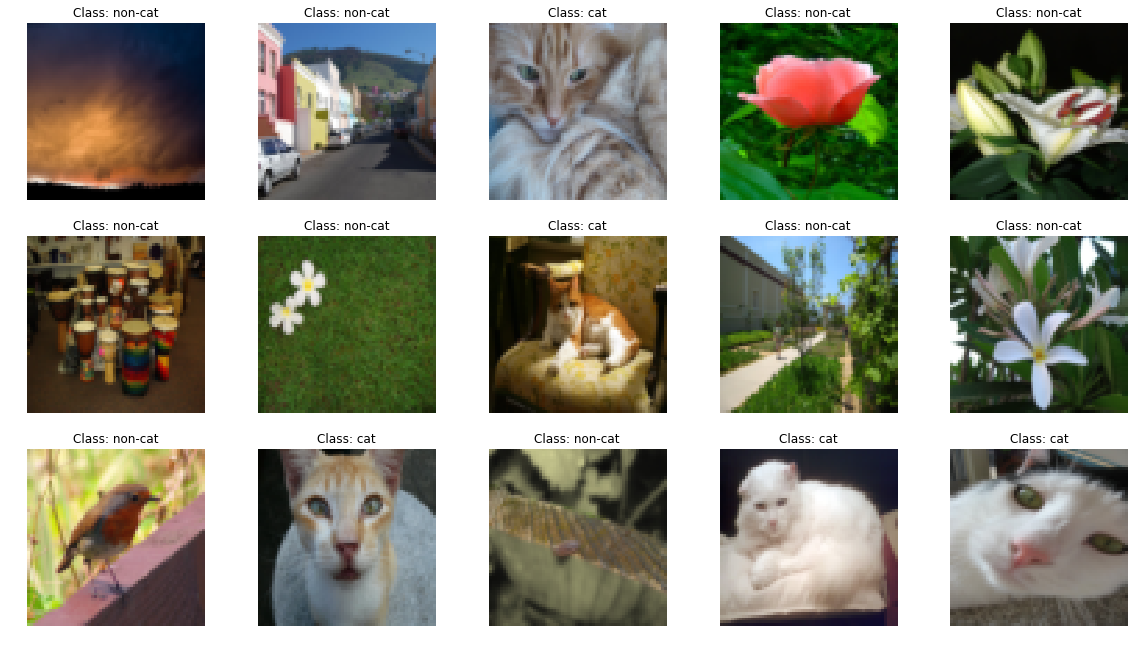

In [36]:
def print_images(classes, X, y, start_index=0, end_index=5):
    """
    Plots images in given range
    X -- dataset
    y -- true labels
    index_range
    """
    indices = np.asarray(range(start_index, end_index))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(indices)
    
    fig = plt.figure(figsize=(20,num_images//5 * 5))
    
    for i in range(num_images):
        index = i
        ax = fig.add_subplot(num_images//5 + 1,5,i+1)
        ax.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        ax.axis('off')
        ax.set_title("Class: " + classes[y[0,index]].decode("utf-8"))
        
        
print_images(classes, train_x, train_y, start_index=5, end_index = 20)

In [4]:
# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


<img src="images/imvectorkiank.png">

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Model architecture

Now that we are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

We will build two different models:

A 2-layer neural network
An L-layer deep neural network
We will then compare the performance of these models, and also try out different values for $L$.

Let's look at the two architectures.

### 3.1 - Two-layer neural network

<img src="images/2layerNN_kiank.png">

- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- We then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- We then repeat the same process.
- We multiply the resulting vector by $W^{[2]}$ and add our intercept (bias).
- Finally, we take the sigmoid of the result. If it is greater than 0.5, we classify it to be a cat.

### 3.2 - L-layer neural network 

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation (again courtesy of Andrew Ng's Deeplearning.ai course):

<img src="images/LlayerNN_kiank.png">

- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then we add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, we take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, we take the sigmoid of the final linear unit. If it is greater than 0.5, we classify it to be a cat.

### 3.3 - General methodology

As usual we will follow the Deep Learning methodology to build the model:

1. Initialise parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
4. Use trained parameters to predict labels

**Now let's implement both a two layer and 5 layer model!**

## 4 - Two-layer model

In [6]:
n_x = train_x.shape[0]
n_h = 7                # Let's go with 7 hidden units
n_y = 1

layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    costs -- list of cost after each repetition
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialise parameters W1, W2, b1, b2
    parameters = initialise_parameters_deep(layers_dims)
    
    for i in range(num_iterations):
        
        # Split out parameters    
        W1 = parameters["W1"]
        W2 = parameters["W2"]
        b1 = parameters["b1"]
        b2 = parameters["b2"]
        
        # Use Linear -> RELU -> Linear -> Sigmoid
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Compute the cost and append to the list of costs (useful for plotting learning curve later)
        cost = compute_cost(A2,Y)
        costs.append(cost)
        
        # Print cots ever 100 iterations if print_cost == True
        if print_cost:
            if i % 100 == 0:
                print(cost)
        
        # Initialise backward propogation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. 
        # Inputs: "dA2, cache2, cache1". 
        # Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
    
    return parameters, costs
    

In [8]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

0.6950464961800915
0.5777750768633237
0.5028737599418062
0.44133032682946277
0.39679294390843645
0.3493794352032143
0.31244746014774566
0.2653497711261275
0.29269008432078797
0.1754057039748196
0.17363959502410775
0.10322806345585982
0.0840669335604764
0.06830485720666676
0.05857629472962355
0.05083318630494658
0.044648831606065115
0.039816219163668176
0.0358013751398867
0.03239644959066732
0.029282999297376225
0.026545112798266362
0.02412190699948059
0.021932508024030427
0.019971742828825176


Text(0.5, 1.0, 'Learning curve')

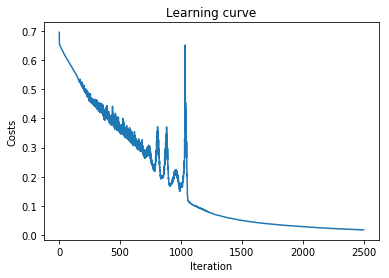

In [9]:
# Let's plot the costs

plt.plot(range(1, len(np.squeeze(costs))+1), np.squeeze(costs))
plt.ylabel("Costs")
plt.xlabel("Iteration")
plt.title("Learning curve")

**Observations:**

As we can see from the above, as the number of iterations increases, the costs generally decreases other than a few laerge spikes, especially one at around the 1000th iteration

#### Now let's use this model to make some predictions

In [10]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [11]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.74


**Observations:**

As we can see, the model is overfitting to a reasonably large degree. Let's run a quick test using different learning rates to see if early stopping is occuring.

In [12]:
for i in [250, 500, 1000, 1250, 1500]:
    parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = i, print_cost=False)
    predict(test_x, test_y, parameters)

Accuracy: 0.6800000000000002
Accuracy: 0.78
Accuracy: 0.7400000000000001
Accuracy: 0.76
Accuracy: 0.74


From the above we can tell that using less iterations seems to produce better results (up to a point of course) as the model becomes worse at generalising to new data after a certain point.

## 5 - L-layer neural network

In [13]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [14]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    costs - List of costs for each iteration
    """
    
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Initialise parameters
    parameters = initialise_parameters_deep(layers_dims)
    
    
    # Gradient descent
    for i in range(num_iterations):
        
        # Forward prop: (Linear -> RELU) * (L - 1) -> Linear -> Sigmoid
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost and add to costs
        cost = compute_cost(AL, Y)
        costs.append(cost)
        
        # Print cots ever 100 iterations if print_cost == True
        if print_cost:
            if i % 100 == 0:
                print(cost)
        
        # Back prop
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate = learning_rate)
        
    return parameters, costs
    

In [15]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

0.7717493284237686
0.6720534400822914
0.6482632048575212
0.6115068816101354
0.5670473268366111
0.54013766345478
0.5279299569455267
0.46547737717668514
0.36912585249592794
0.39174697434805356
0.3151869888600617
0.2726998441789385
0.23741853400268137
0.19960120532208647
0.18926300388463305
0.1611885466582775
0.14821389662363316
0.13777487812972944
0.1297401754919012
0.12122535068005211
0.11382060668633713
0.10783928526254132
0.10285466069352679
0.10089745445261787
0.09287821526472397


Text(0.5, 1.0, 'Learning curve')

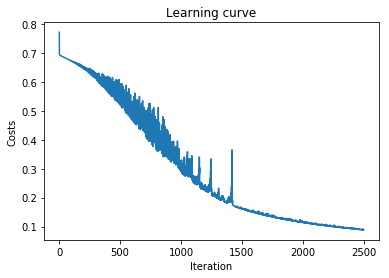

In [16]:
# Let's plot the costs

plt.plot(range(1, len(np.squeeze(costs))+1), np.squeeze(costs))
plt.ylabel("Costs")
plt.xlabel("Iteration")
plt.title("Learning curve")

**Let's make some predictions and determine the train and test accuracy**

In [17]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [18]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Observations:**

As we can see, the 5 layer model has boosted accuracy to 80%. Not bad!

## 6 - Results analysis

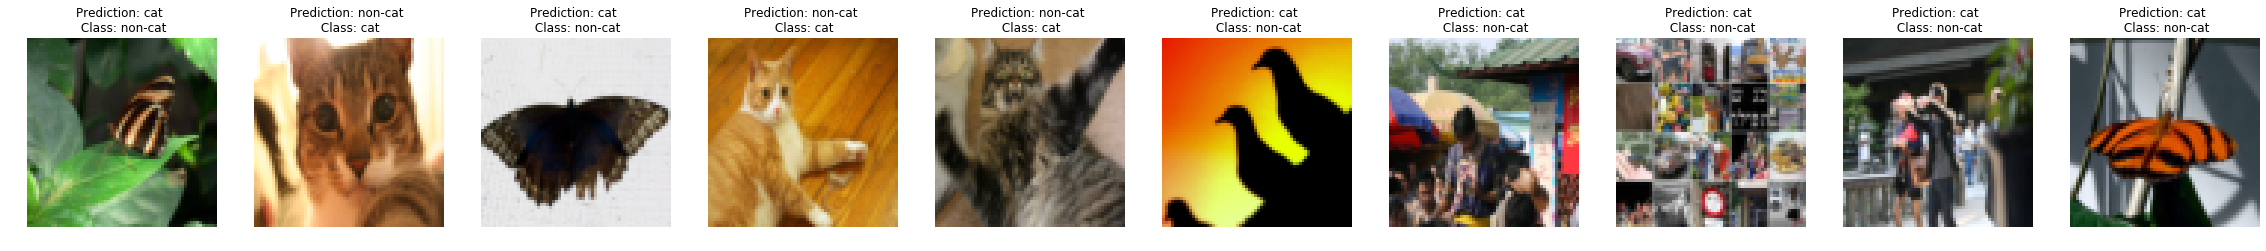

In [21]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:**

- Cat body in an unusual position
- Cat appears against a background of a similar color
- Object in image is similar in color and shape to a cat (see butterflys above)